In [21]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## SECTION - DATA PROCESSING

In [22]:
import os
from yaml import safe_load
from imdlib import get_data
from pandas import read_csv, concat, DataFrame, pivot_table
from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt

### Function - Remove Files and Folders (if any)

- **Purpose** - Clean the "../data" folder of any data

- **Input** - directory location

In [23]:
# Function - Remove Files and Folder (if exisitng)
def remove_data(dirName):
    for root, dirs, files in os.walk(dirName, topdown=False):
        for name in files:
            os.remove(os.path.join(root, name))
        for name in dirs:
            os.rmdir(os.path.join(root, name))

### Function - Get RAW Data from IMD Pune

- **Purpose** - Get RAW Data from IMD Pune website and store in "../data/raw" folder

- **Input** - Start year, End year, and Varaible (rain, tmin, tmax)

- **Output** - CSV File for each varaible (un-cleaned data).
Columns in each raw file are
    - *time* = Date at which data is extracted in YYYY-MM-DD format
    
    - *lat* = Latitude information

    - *lon* = Longitude information
    
    - *rain* / *tmin* / *tmax* = Information on Rainflall, Min temperature, Max temperature

- **Note** - "../data/raw" is not pushed to GITHUB due to size constraint in account.

In [24]:
# Function - Get RAW Database from IMD Pune
def get_raw_data(var):
    global configDatabase
    
    # Download Data from Website
    data = get_data(var, configDatabase['startYear'], configDatabase['endYear'], 
                    fn_format='yearwise', file_dir=configDatabase['dir']['dataRAW'])
    
    # Convert Data to Dataframe
    df = data.get_xarray().to_dataframe()
    df = df[df[var] != df[var].mode()[0]]
    
    # Write Dataframe to CSV
    df.to_csv(os.path.join(configDatabase['dir']['dataRAW'], var + '.csv'), compression='gzip')
    remove_data(configDatabase['dir']['dataRAW'] + '/' + var)
    os.rmdir(configDatabase['dir']['dataRAW'] + '/' + var)

### Function - Convert RAW Data to Interim Data

- **Purpose** - RAW data consist of three seperate files for each variable. 
Function combines (inner join) the three CSV files to give single file.

- **Input** - CSV files from "../data/raw" which contains RAW data.

- **Output** - CSV file ("imd_database.csv") to "../data/interim" which contains INTERIM data.
Columns in the interim data are
    - *time* = Date at which data is extracted in YYYY-MM-DD format

    - *day* = Number of days from "Start Date".

    - *month* = Month information extracted from *time* column.

    - *year* = Year infomation extracted from *time* column.

    - *lat* = Latitude information

    - *lon* = Longitude information

    - *pos* = Tuple of Latitude and Longitude.
     
    - *rain* = Amount of Rainfall of particular day

    - *tmin* = Min temperature of particular day

    - *tmax* = Max temperature of particular day


In [25]:
# Function - Interim Database
def create_interim_data():
    global configDatabase
    
    # Read RAW Database
    dfrain = read_csv(configDatabase['dir']['dataRAW'] + '/' + configDatabase['importVar'][0] + '.csv', index_col=['time', 'lat', 'lon'], compression='gzip')
    dftmin = read_csv(configDatabase['dir']['dataRAW'] + '/' + configDatabase['importVar'][1] + '.csv', index_col=['time', 'lat', 'lon'], compression='gzip')
    dftmax = read_csv(configDatabase['dir']['dataRAW'] + '/' + configDatabase['importVar'][2] + '.csv', index_col=['time', 'lat', 'lon'], compression='gzip')
    
    # Combine Databases
    df = concat([dfrain, dftmin, dftmax], axis=1, join="inner")
    
    # Process Database
    startDate = datetime.strptime(configDatabase['startDate'], "%Y-%m-%d")
    df = df.reset_index()
    df['pos'] = df.apply(lambda x: (x.lat, x.lon), axis=1)
    df['time'] = df.apply(lambda x: datetime.strptime(x.time, "%Y-%m-%d") , axis=1)
    df['year'] = df.apply(lambda x: x.time.year, axis=1)
    df['month'] = df.apply(lambda x: x.time.month, axis=1)
    df['day'] = df.apply(lambda x: (x.time - startDate).days, axis=1)
    df = df[['time', 'day', 'month', 'year', 'lat', 'lon', 'pos', 'rain', 'tmin', 'tmax']]
    df.to_csv(os.path.join(configDatabase['dir']['dataInterim'], configDatabase['file']['interim']), index=False, compression='gzip')

### Function - Processed Data (Daily)

- **Purpose** = Clean and process interim data and convert to training and testing dataset for modelling.
Cleaning mainly include handling missing data by any of three approaches:
    - Fill with last valid entry

    - Fill with next valid entry

    - Linear interpolation b/w two valid entries (currently being used)

- **Input** = CSV file to "../data/interim" which contains INTERIM data.

- **Output** = CSV file (prefix is "imd_daily") to "../data/processed" which contains PROCESS daily training and testing data.
Columns in the processed data are
    - *day* - Number of days from "Start Date".

    - *pos* - Tuple of Latitude and Longitude.

    - *rain* - Amount of Rainfall of particular day

    - *tmin* - Min temperature of particular day

    - *tmax* - Max temperature of particular day

- **Note** = Split between training and testing data is based of "Cut Date"

In [26]:
# Function - Processed Database (Daily)
def create_process_data_daily():
    global configDatabase
    
    # Read Interim Database
    df = read_csv(os.path.join(configDatabase['dir']['dataInterim'], configDatabase['file']['interim']), compression='gzip')
    df = df[['day', 'pos', 'rain', 'tmin', 'tmax']]
    df = df[df.pos.isin(df.pos.unique()[:300])]
    
    # Process Database - Add Missing Data as NaN
    dayFull = list(range(df.day.max()+1))
    dayList = []
    posList = []
    for loc in df.pos.unique():
        dayPresent = df[df.pos == loc].day
        dayMissing = list(set(dayFull).symmetric_difference(set(dayPresent)))
        dayList.extend(dayMissing)
        posList.extend([loc]*len(dayMissing))
    temp = DataFrame(list(zip(dayList, posList, [np.NaN]*len(dayList), [np.NaN]*len(dayList), [np.NaN]*len(dayList))), 
                     columns =['day', 'pos', 'rain', 'tmin', 'tmax'])
    df = concat([df, temp])
    df.sort_values(by=['day', 'pos'], inplace=True)
    df.reset_index(inplace=True, drop=True)
    
    # Process Database - Handle Missing Data
    #df[['rain', 'tmin', 'tmax']] = df[['rain', 'tmin', 'tmax']].fillna(method='ffill')       # Last Valid Observation
    #df[['rain', 'tmin', 'tmax']] = df[['rain', 'tmin', 'tmax']].fillna(method='bfill')       # Next Valid Observation
    df[['rain', 'tmin', 'tmax']] = df[['rain', 'tmin', 'tmax']].interpolate('linear')         # Interpolate 
    
    # Split Training and Testing Database
    startDate = datetime.strptime(configDatabase['startDate'], "%Y-%m-%d")
    cutDate = datetime.strptime(configDatabase['cutDate'], "%Y-%m-%d")
    dayID = (cutDate - startDate).days
    index = df[df.day == dayID-1].index[-1]
    dfTrain = df.iloc[:index+1,:]
    dfTest = df.iloc[index+1:,:]
    dfTrain.to_csv(os.path.join(configDatabase['dir']['dataProcess'], configDatabase['file']['train01']), index=False, compression='gzip')
    dfTest.to_csv(os.path.join(configDatabase['dir']['dataProcess'], configDatabase['file']['test01']), index=False, compression='gzip')

### Function - Processed Data (Monthly)

- **Purpose** = Clean and process interim data and convert to training and testing dataset for modelling.
Conversion of daily data to monthly data involves creation of new varaibles
    - For rain = extract sum, mean and standard deviation of data in given month

    - For tmin = extract mean and standard deviation of data in given month

    - For tmax = extract mean and standard deviation of data in given month

- **Input** = CSV file to "../data/interim" which contains INTERIM data.

- **Output** = CSV file (prefix is "imd_monthly") to "../data/processed" which contains PROCESS monthly training and testing data.
Columns in the processed data are
    - *pos* - Tuple of Latitude and Longitude.

    - *monthID* - Number of months from "Start Date".

    - *rain_sum* - Sum of amount of Rainfall of particular month.

    - *rain_mean* - Mean of amount of Rainfall of particular month.

    - *rain_std* - Standard Deviation of amount of Rainfall of particular month.

    - *tmin_mean* - Mean of the min temperature of particular month.

    - *tmin_std* - Standard Deviation of the min temperature of particular month.

    - *tmax_mean* - Mean of the max temperature of particular month.

    - *tmax_std* - Standard Deviatin of the max temperature of particular month.

- **Note** = Split between training and testing data is based of "Cut Date"

In [27]:
# Function - Processed Database (Monthly)
def create_process_data_monthly():
    global configDatabase
    
    # Read Interim Database
    df = read_csv(os.path.join(configDatabase['dir']['dataInterim'], configDatabase['file']['interim']), compression='gzip')
    df = df[['year', 'month', 'pos', 'rain', 'tmin', 'tmax']]
    df = df[df.pos.isin(df.pos.unique()[:300])]
    
    # Process Database - Pivot Table Monthly
    df['monthID'] = 12*(df.year - df.year.min()) + df.month
    tableRain = pivot_table(df, values='rain', index=['pos', 'monthID'], aggfunc=["sum", "mean", "std"])
    tableTmin = pivot_table(df, values='tmin', index=['pos', 'monthID'], aggfunc=["mean", "std"])
    tableTmax = pivot_table(df, values='tmax', index=['pos', 'monthID'], aggfunc=["mean", "std"])
    dfMonth = concat([tableRain, tableTmin, tableTmax], axis=1, join="inner")
    dfMonth.reset_index(inplace=True)
    dfMonth.sort_values(by=['monthID', 'pos'], inplace=True)
    dfMonth.columns = ['pos', 'monthID', 'rain_sum', 'rain_mean', 'rain_std', 'tmin_mean', 'tmin_std', 'tmax_mean', 'tmax_std']
    dfMonth.reset_index(inplace=True, drop=True)
    
    # Split Training and Testing Database
    cutMonth = 12*(int(configDatabase['cutDate'].split('-')[0]) - df.year.min()) + int(configDatabase['cutDate'].split('-')[1])
    print(cutMonth)
    index = dfMonth[dfMonth.monthID == cutMonth-1].index[-1]
    dfTrain = dfMonth.iloc[:index+1,:]
    dfTest = dfMonth.iloc[index+1:,:]
    dfTrain.to_csv(os.path.join(configDatabase['dir']['dataProcess'], configDatabase['file']['train02']), index=False, compression='gzip')
    dfTest.to_csv(os.path.join(configDatabase['dir']['dataProcess'], configDatabase['file']['test02']), index=False, compression='gzip')

### MAIN CODE

- **Note** = Comment the lines which are not needed.

In [ ]:
# Main Code
configDatabase = safe_load(open("../config.yaml"))
#configDatabase

#remove_data(configDatabase['dir']['dataRAW'])
#remove_data(configDatabase['dir']['dataInterim'])
remove_data(configDatabase['dir']['dataProcess'])

#for varName in configDatabase['importVar']: get_raw_data(varName)

#create_interim_data()

create_process_data_daily()
create_process_data_monthly()


241


## SECTION - VISUALISATION

### Visualize Random Locations Daily Training Data

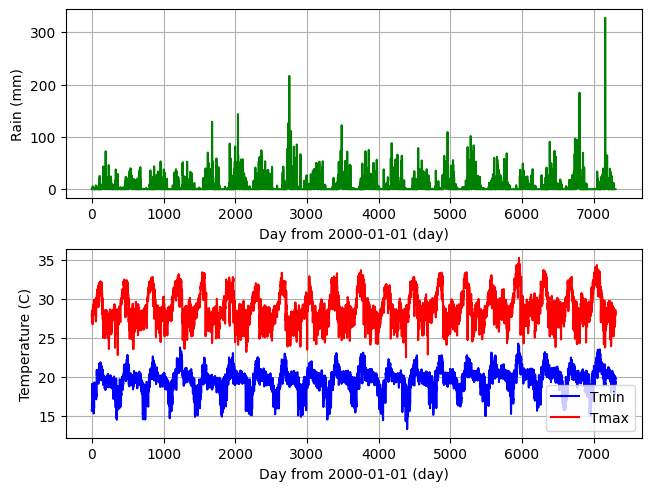

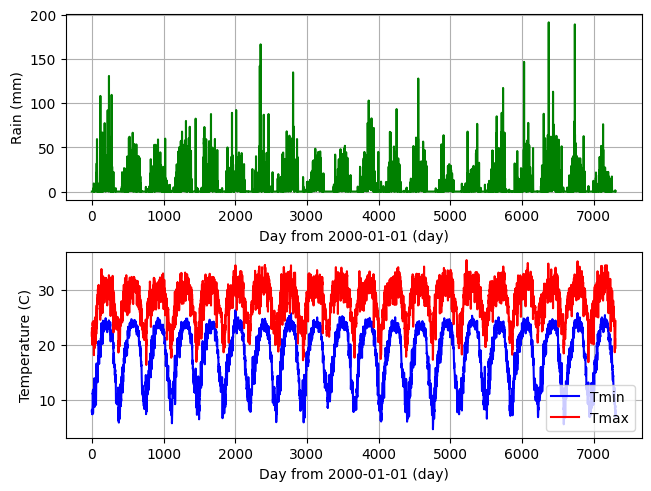

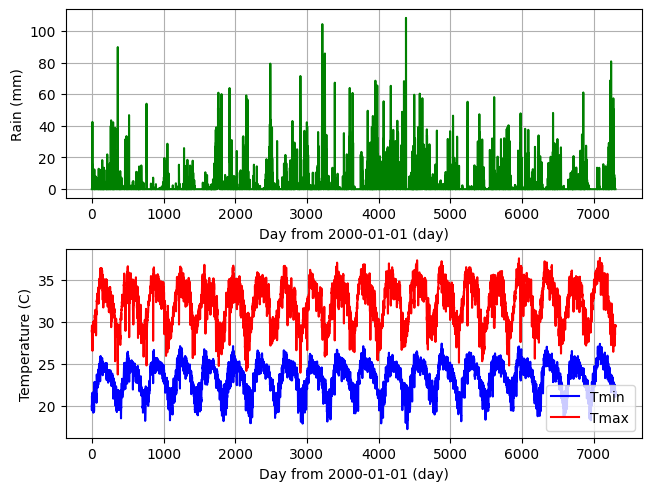

In [29]:
# Visulaization of Proceesed Data (Daily Training Data)
def plot_daily(df, reqID):
    reqPos = df.pos.unique()[reqID]
    day = df[df.pos == reqPos].day
    rain = df[df.pos == reqPos].rain
    tmin = df[df.pos == reqPos].tmin
    tmax = df[df.pos == reqPos].tmax

    fig, axs = plt.subplots(2, 1, layout='constrained')
    axs[0].plot(day, rain, label="Rain", color='g')
    axs[0].set_xlabel('Day from 2000-01-01 (day)')
    axs[0].set_ylabel('Rain (mm)')
    axs[0].grid(True)
    axs[1].plot(day, tmin, label="Tmin", color='b')
    axs[1].plot(day, tmax, label="Tmax", color='r')
    axs[1].set_xlabel('Day from 2000-01-01 (day)')
    axs[1].set_ylabel('Temperature (C)')
    axs[1].grid(True)
    axs[1].legend()
    plt.show()

# MAIN CODE
df = read_csv(os.path.join(configDatabase['dir']['dataProcess'], configDatabase['file']['train01']), compression='gzip')
plot_daily(df, 0)
plot_daily(df, 149)
plot_daily(df, 299)

### Visualize Random Locations Monthly Training Data

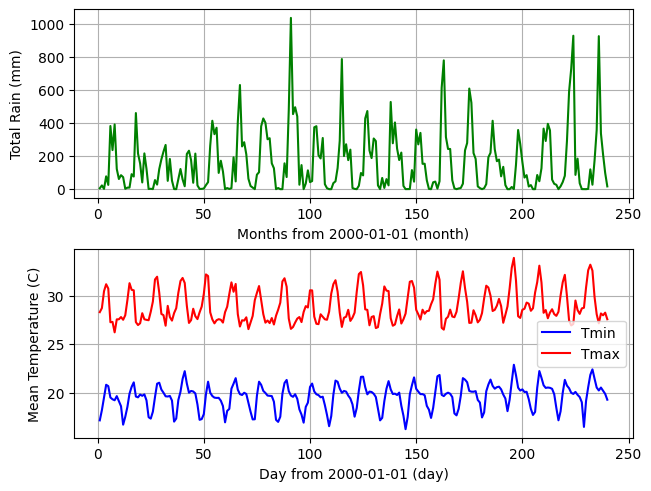

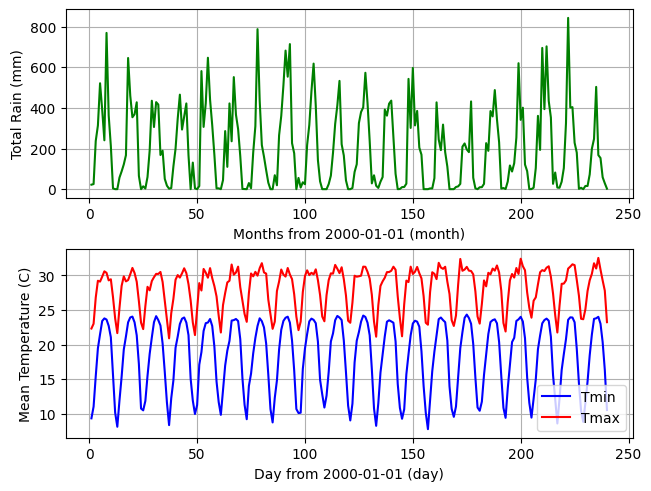

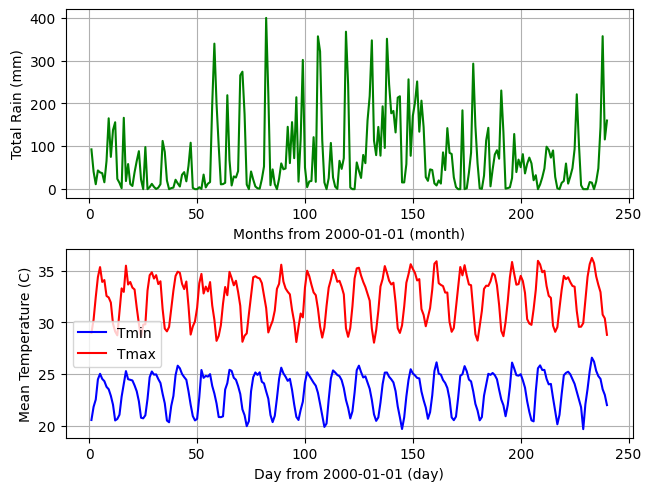

In [30]:
# Visulaization of Processed Data (Monthly Training Data)
def plot_monthly(df, reqID):
    reqPos = df.pos.unique()[reqID]
    day = df[df.pos == reqPos].monthID
    rain = df[df.pos == reqPos].rain_sum
    tmin = df[df.pos == reqPos].tmin_mean
    tmax = df[df.pos == reqPos].tmax_mean

    fig, axs = plt.subplots(2, 1, layout='constrained')
    axs[0].plot(day, rain, label="Rain", color='g')
    axs[0].set_xlabel('Months from 2000-01-01 (month)')
    axs[0].set_ylabel('Total Rain (mm)')
    axs[0].grid(True)
    axs[1].plot(day, tmin, label="Tmin", color='b')
    axs[1].plot(day, tmax, label="Tmax", color='r')
    axs[1].set_xlabel('Day from 2000-01-01 (day)')
    axs[1].set_ylabel('Mean Temperature (C)')
    axs[1].grid(True)
    axs[1].legend()
    plt.show()

# MAIN CODE
df = read_csv(os.path.join(configDatabase['dir']['dataProcess'], configDatabase['file']['train02']), compression='gzip')
plot_monthly(df, 0)
plot_monthly(df, 149)
plot_monthly(df, 299)